# Introduction
* In this Jupyter Notebook, we will load the train and test data and merge them. 
* After that, we will define churn and analyze customer behavior over time.

### Churn Definition
* Churn is defined as the inactivity between transactions of customers greater than 365 days (12 months). 
* These data points are classified as churn. 
* The following image illustrates the churn definition:

![Churn Definition](../diagrams/churn_definition.png)



* In the image, the x-axis represents the timeline of customer transactions
* and the y-axis represents different customers. 
* A red mark indicates a churn event, which occurs when the inactivity period between two transactions exceeds 365 days.

In [1]:
import os
os.chdir('../../')

In [2]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import gc

## Read all the parquet files matching the pattern `./week_1/data/raw/train_*.parquet`

In [3]:
train_files = glob.glob('./week_1/data/raw/train_*.parquet')
train_df = pd.concat([pd.read_parquet(file) for file in train_files], ignore_index=True)

# Set Id as the index and drop the Id column
train_df.set_index('Id', inplace=True)

train_df.info()

max_train_date = train_df['date'].max()
min_train_date = train_df['date'].min()

print(f"Max date: {max_train_date}")
print(f"Min date: {min_train_date}")

<class 'pandas.core.frame.DataFrame'>
Index: 3926058 entries, 978127 to 462039
Data columns (total 25 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   customer_id               int64         
 1   interest_rate             float64       
 2   name                      object        
 3   country                   object        
 4   date_of_birth             object        
 5   address                   object        
 6   date                      datetime64[ns]
 7   atm_transfer_in           int64         
 8   atm_transfer_out          int64         
 9   bank_transfer_in          int64         
 10  bank_transfer_out         int64         
 11  crypto_in                 int64         
 12  crypto_out                int64         
 13  bank_transfer_in_volume   float64       
 14  bank_transfer_out_volume  float64       
 15  crypto_in_volume          float64       
 16  crypto_out_volume         float64       
 17  complaint

## Merging Dataframes

In [4]:

# Read the test.parquet file
test_df = pd.read_parquet('./week_1/data/raw/test.parquet')

# Set Id as the index and drop the Id column
test_df.set_index('Id', inplace=True)

max_test_date = test_df['date'].max()
min_test_date = test_df['date'].min()
print(f"Max test date: {max_test_date}")
print(f"Min test date: {min_test_date}")

# Merge train_df and test_df into a new dataframe called df 
df = pd.concat([train_df, test_df])
print(f"Max full dataset date: {df['date'].max()}")
print(f"Min full dataset date: {df['date'].min()}")

# Clean memory usage by setting train_df and test_df to null
train_df = None
test_df = None

# Call garbage collector
gc.collect()

Max test date: 2026-12-31 00:00:00
Min test date: 2024-01-01 00:00:00
Max full dataset date: 2026-12-31 00:00:00
Min full dataset date: 2008-01-17 00:00:00


0

In [5]:
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

Memory usage: 4251.09 MB


## Define Churn Variable

In [7]:
max_inactivity = 365
df['churn'] = 0
df = df.sort_values(['customer_id', 'date'], ascending=True)
df['next_date'] = df.groupby('customer_id')['date'].shift(-1)
#train_df['next_date'].fillna(max_dataset_date, inplace=True)
df['days_diff'] = (df['next_date'] - df['date']).dt.days
df.loc[df['days_diff'] >= max_inactivity, 'churn'] = 1

# churn on the full train period
print(df.loc[df.date < '2023-01-01', 'churn'].value_counts())
print(df.loc[df.date < '2023-01-01', 'churn'].value_counts(normalize=True))

churn
0    3153889
1     364564
Name: count, dtype: int64
churn
0    0.896385
1    0.103615
Name: proportion, dtype: float64


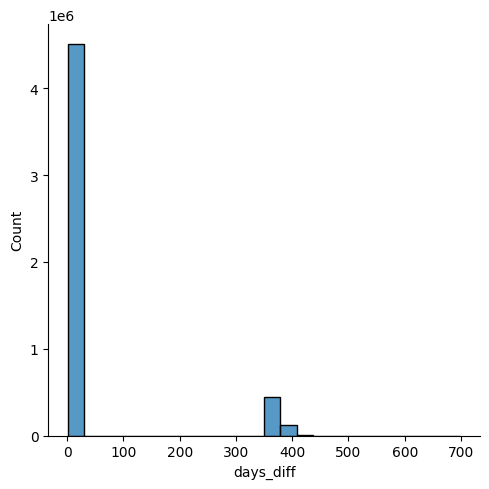

In [10]:
sns.displot(df.loc[df.days_diff < 700,'days_diff'], kde=False)

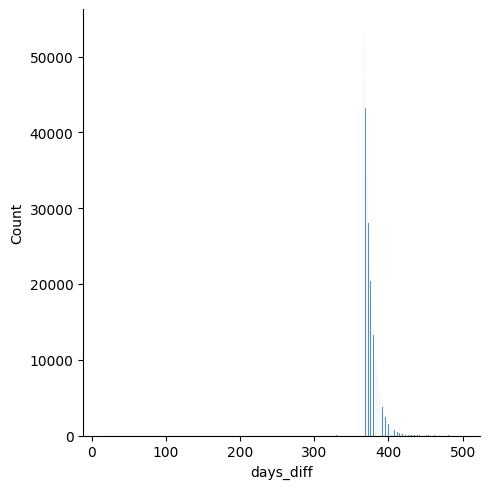

In [13]:
sns.displot(df.loc[(df.days_diff > 10) & (df.days_diff < 500),'days_diff'], kde=False)

<Axes: xlabel='days_diff', ylabel='Proportion'>

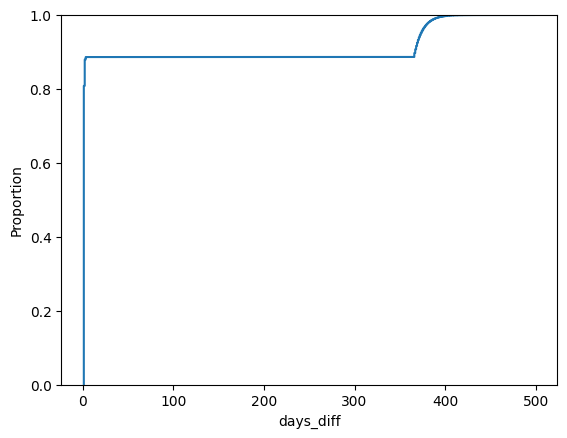

In [16]:
sns.ecdfplot(df.loc[df.days_diff < 500,'days_diff'])

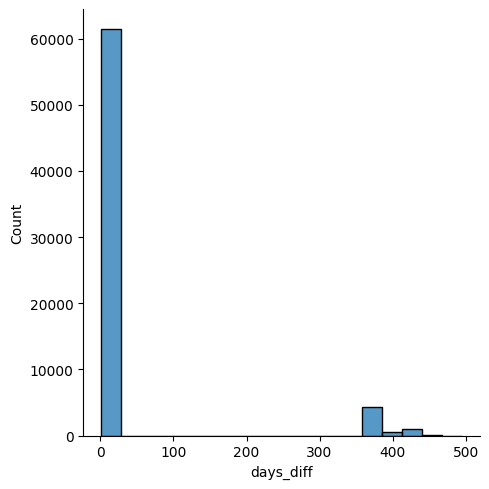

In [68]:
customers_with_big_inactivity = train_df.loc[train_df.days_diff >= 420, 'customer_id'].unique()
sns.displot(train_df.loc[train_df.customer_id.isin(customers_with_big_inactivity), 'days_diff']) 

## Data Split
* In this section, we define the split strategy for our dataset. 
* The dataset is divided into three periods: train, validation, and test. 
* The train period includes data up to December 31, 2022. 
* The validation period spans from January 1, 2023, to December 31, 2023. 
* The test period starts from January 1, 2024, onwards.

The following image illustrates the dataset split strategy:

![Dataset Split Strategy](../diagrams/churn_data_split.png)



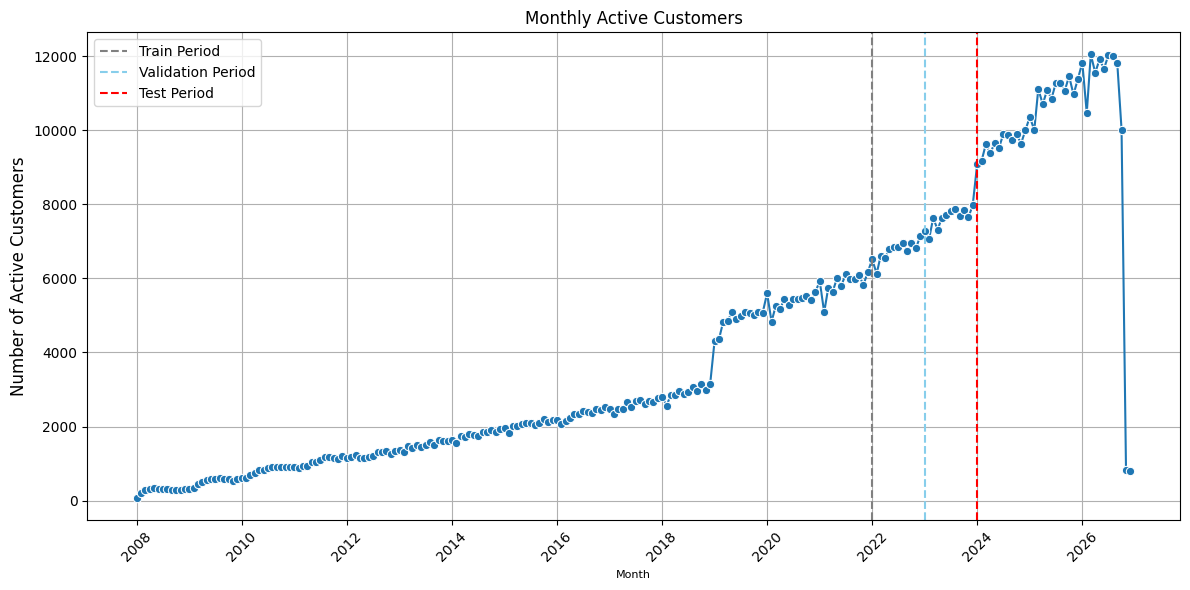

In [102]:
# Count unique active monthly customers
df['date_trunc_month'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly_active_customers = df.groupby(df['date_trunc_month'])['customer_id'].nunique().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_active_customers, x='date_trunc_month', y='customer_id', marker='o')

plt.axvline(pd.Timestamp('2022-01-01'), color='gray', linestyle='--', label='Train Period')
plt.axvline(pd.Timestamp('2023-01-01'), color='skyblue', linestyle='--', label='Validation Period')
plt.axvline(pd.Timestamp('2024-01-01'), color='red', linestyle='--', label='Test Period')
plt.legend()

# Beautify the plot
plt.title('Monthly Active Customers', fontsize=12)
plt.xlabel('Month', fontsize=8)
plt.ylabel('Number of Active Customers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [21]:
df['split'] = 'train'
df.loc[df.date >= '2023-01-01', 'split'] = 'validation'
df.loc[df.date >= '2024-01-01', 'split'] = 'test'

df

,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,bank_transfer_in,...,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud,Usage,churn,next_date,days_diff,split
Id,,,,,,,,,,,,,,,,,,,,,
1,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-17,0,0,17476,...,0,False,Amenity horticulturist,False,False,NaN,0,2008-01-18,1.0,train
6,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-18,0,0,19680,...,1,False,Amenity horticulturist,False,False,NaN,0,2008-01-19,1.0,train
16,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-19,0,0,17958,...,2,False,Amenity horticulturist,False,False,NaN,0,2008-01-20,1.0,train
31,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-20,0,0,22772,...,3,False,Amenity horticulturist,False,False,NaN,0,2008-01-21,1.0,train
50,1,3.5,Yolanda Parker,Lithuania,1954-07-10,"1929 Erin Lights Suite 709\nLake Michaelburgh,...",2008-01-21,0,0,23610,...,4,False,Amenity horticulturist,False,False,NaN,0,2008-01-23,2.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545935,165320,0.0,Mrs. Carol Foley,Romania,1994-12-19,"2393 William Drive\nAlyssaton, MT 01733 Romania",2026-10-25,0,0,1874,...,0,False,"Conservation officer, historic buildings",False,False,Private,0,NaT,NaN,test
7545926,165321,0.0,William Hall,Czech Republic,1972-03-20,"4717 Olivia Brook\nSouth Josephton, DC 82766 C...",2026-10-25,0,0,266,...,0,False,unemployed,False,False,Private,0,NaT,NaN,test
7545923,165322,0.0,Jessica Logan,Switzerland,1991-11-06,"24882 Williams Street Suite 534\nNew Ryan, MI ...",2026-10-25,0,0,2,...,0,True,"Engineer, civil (contracting)",False,False,Private,0,NaT,NaN,test


In [ ]:
df.to_parquet('./week_1/data/processed/full_dataset.parquet')